In this repository, I have implemented a document classifier based on [Deepdocclassifier: Document classification with deep Convolutional Neural Network](https://ieeexplore.ieee.org/document/7333933) (DCNN), which is trained and evaluated using the Tobacco-3482 dataset. I have partitioned the dataset into five partitions with different sizes for training and validation datasets for assessing the network. Five partitions used for evaluation include 20, 40, 60, 80, and 100 samples used for training and validations. The rest of the images are used for testing purposes. This evaluation method is taken from the original approach to compare results. To compare results, similar to the original paper, results are compared with [Convolutional Neural Networks for Document Image Classification](https://projet.liris.cnrs.fr/imagine/pub/proceedings/ICPR-2014/data/5209d168.pdf) (CNN).

In this repository, DCNN and CNN are implemented using PyTorch and PyTorchLightning. To create partitions of data with different training and validation sizes, `LightningDataModule` is used, consumed by the Trainer class of PyTorchLightning. 

Both DCNN and CNN are trained using locally using 
- Processor: Intel(R) Core(TM) i7-10510U CPU @ 1.80GHz 2.30 GHz and 
- GPU: NVIDIA GeForce MX230

Before training the neural network, the package from the repository is installed using the setup file. After installing the requirements using the `requirement.txt` file, the package can be installed locally after cloning the repository and running the below command from the home of the repository:
```{bash}
pip install .
```

After installing the repository into local, the DCNN method is trained using configuration from YAML file, provided in `config/deepDocConfig.yaml`. The neural network can be trained by executing the python module from the command line as below:

```{bash}
python -m deepDocClassifier.main -c <path of config file>
```

After training each model using different partitions of the training and validation dataset, the remaining samples are used as test data for evaluation. All models are tested using the remaining samples, and a CSV file is generated for further evaluation. The training process is logged using tensorboard and pushed to [tensorboard dev](https://tensorboard.dev/experiment/sL0GDdIbQxiGEuxRQ6kIGw/#scalars) for reference.

Using the tensorboard logs and test results, I have generated the learning curve, comparing results on test data for DCNN and CNN. Finally, a confusion matrix plot is plotted for the DCNN method for a partition using 100 samples.

In [1]:
# imports
# path of the dir containing, tf event files
import os
import glob
from pprint import pprint

import numpy as np
import pandas as pd
import traceback
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import seaborn as sns
import traceback
import sklearn.metrics as sklmetrics

#imports for results
import torch
import matplotlib as mpl

from tqdm import tqdm
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator

# sns.set()
sns.set_theme(style="whitegrid")
sns.set_palette("bright")

### Utility methods for extracting tensorboard eventfile

In [2]:
# Extraction function
def tflog2pandas(path: str) -> pd.DataFrame:
    """convert single tensorflow log file to pandas DataFrame
    copied from : https://github.com/theRealSuperMario/supermariopy/blob/9fff8275278ff26caff50da86109c25d276bb30b/scripts/tflogs2pandas.py#L14
    Parameters
    ----------
    path : str
        path to tensorflow log file
    Returns
    -------
    pd.DataFrame
        converted dataframe
    """
    DEFAULT_SIZE_GUIDANCE = {
        "compressedHistograms": 1,
        "images": 1,
        "scalars": 0,  # 0 means load all
        "histograms": 1,
    }
    runlog_data = pd.DataFrame({"metric": [], "value": [], "step": []})
    try:
        event_acc = EventAccumulator(path, DEFAULT_SIZE_GUIDANCE)
        event_acc.Reload()
        tags = event_acc.Tags()["scalars"]
        for tag in tags:
            event_list = event_acc.Scalars(tag)
            values = list(map(lambda x: x.value, event_list))
            step = list(map(lambda x: x.step, event_list))
            r = {"metric": [tag] * len(step), "value": values, "step": step}
            r = pd.DataFrame(r)
            runlog_data = pd.concat([runlog_data, r])
    # Dirty catch of DataLossError
    except Exception:
        print("Event file possibly corrupt: {}".format(path))
        traceback.print_exc()
    return runlog_data


def many_logs2pandas(event_paths):
    all_logs = pd.DataFrame()
    for path in event_paths:
        log = tflog2pandas(path)
        if log is not None:
            if all_logs.shape[0] == 0:
                all_logs = log
            else:
                all_logs = all_logs.append(log, ignore_index=True)
    return all_logs

In [3]:
log_home_dir = r'C:\workspace\dfki-task\logs'

In [4]:
models_log_dir = {
    'DCNN': {
        '20': r'deepDocClassifier\torchvision\dataSize_20\version_0',
        '40': r'deepDocClassifier\torchvision\dataSize_40\version_0',
        '60': r'deepDocClassifier\torchvision\dataSize_60\version_0',
        '80': r'deepDocClassifier\torchvision\dataSize_80\version_0',
        '100': r'deepDocClassifier\torchvision\dataSize_100\version_0',
        
    },
    'CNN': {
        '20': r'CNNDoc\dataSize_20\version_0',
        '40': r'CNNDoc\dataSize_40\version_0',
        '60': r'CNNDoc\dataSize_60\version_0',
        '80': r'CNNDoc\dataSize_80\version_0',
        '100': r'CNNDoc\dataSize_100\version_0',
        
    }
}

## Learning Curve for DCNN and CNN

Extract scalars from tensorboard event files, and plot learning curve for DCNN and CNN methods.

DCNN: Afzal, M. Z., Capobianco, S., Malik, M. I., Marinai, S., Breuel, T. M., Dengel, A., & Liwicki, M. (2015). Deepdocclassifier: Document classification with deep Convolutional Neural Network. Proceedings of the International Conference on Document Analysis and Recognition, ICDAR, 2015-Novem, 1111–1115. https://doi.org/10.1109/ICDAR.2015.7333933

CNN: Kang, L., Kumar, J., Ye, P., Li, Y., & Doermann, D. (2014). Convolutional neural networks for document image classification. Proceedings - International Conference on Pattern Recognition, 3168–3172. https://doi.org/10.1109/ICPR.2014.546

Below plots shows the learning curve using five different partitions, using number of samples for training and validation data equal to 20, 40, 60, 80, and 100. 

In [5]:
# extract model log 

models_log_df = {}

for method in models_log_dir:
    models_log_df[method] = {}
    for model in models_log_dir[method]:
        log_dir_path = os.path.join(log_home_dir, models_log_dir[method][model])
        
        if os.path.isdir(log_dir_path):
            event_paths = glob.glob(os.path.join(log_dir_path, "event*"))
        else:
            raise ValueError(f"{log_dir_path} is not a valid dir path")
            
        models_log_df[method][model] = many_logs2pandas(event_paths)
        
        

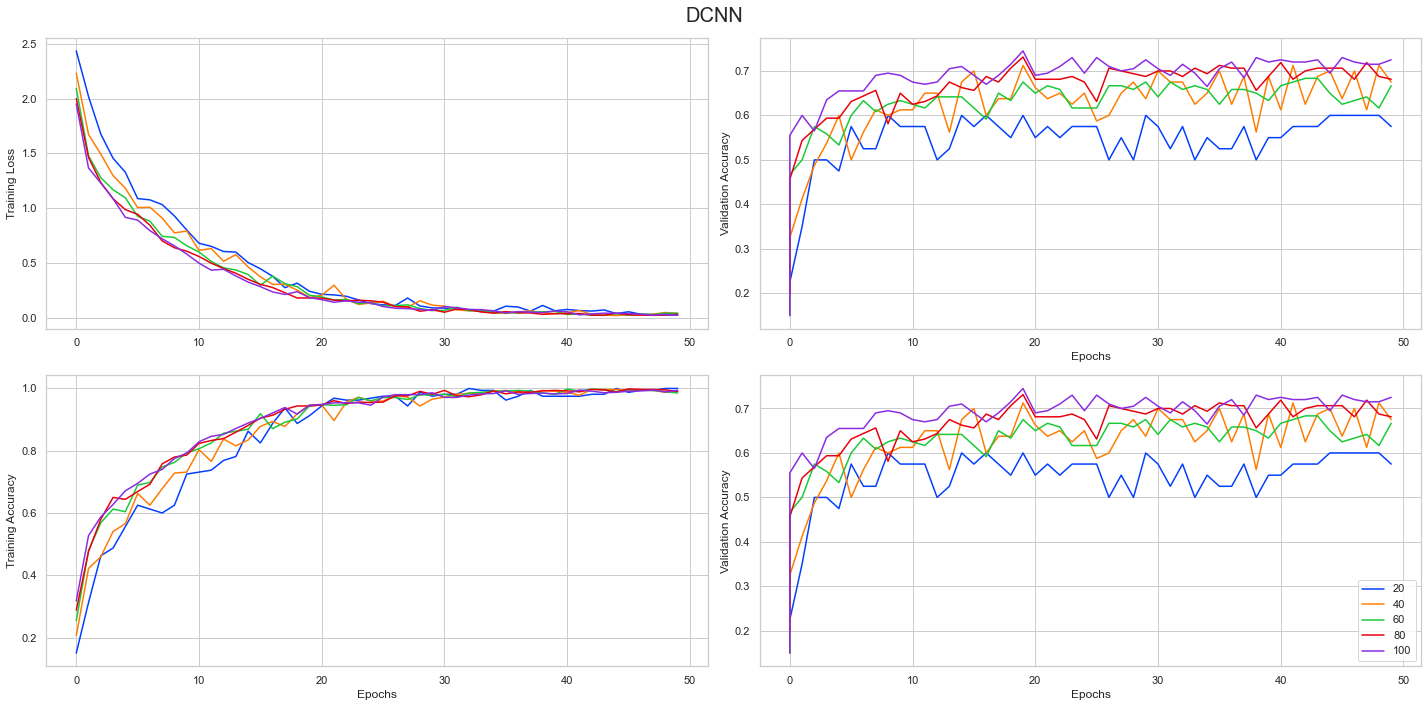

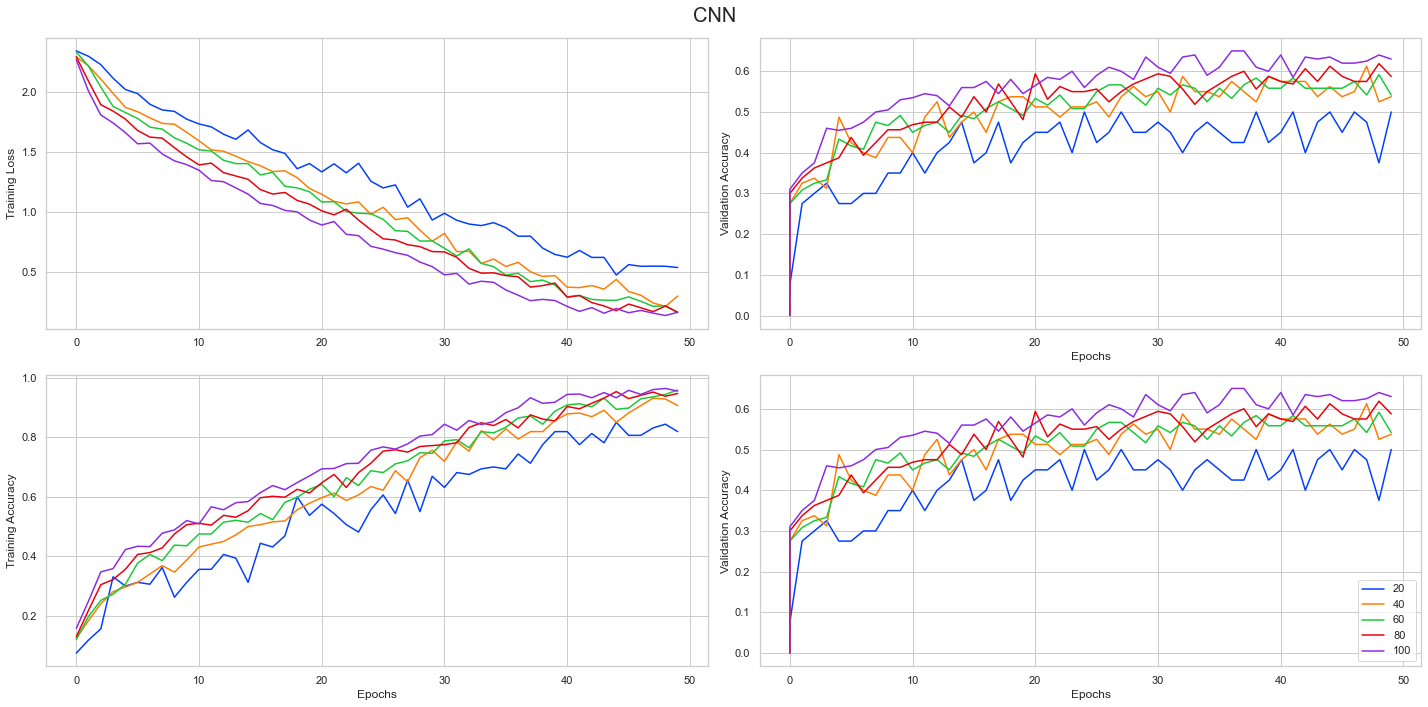

In [6]:
# learning curve
for method in models_log_df:
    fig, axs = plt.subplots(2,2, figsize=(20,10))
    fig.suptitle(method, fontsize=20)
    for model in models_log_df[method]:
        df = models_log_df[method][model]
        plt.sca(axs[0][0])
        metric = df[df['metric']=='train_epoch_loss']
        plt.plot(metric['step'], metric['value'])
        plt.ylabel("Training Loss")
        
        plt.sca(axs[1][0])
        metric = df[df['metric']=='train_epoch_acc']
        plt.plot(metric['step'], metric['value'])
        plt.ylabel("Training Accuracy")
        plt.xlabel("Epochs")
        
        plt.sca(axs[0][1])
        metric = df[df['metric']=='val_epoch_acc']
        plt.plot(metric['step'], metric['value'])
        plt.ylabel("Validation Accuracy")
        plt.xlabel("Epochs")
        
        plt.sca(axs[1][1])
        metric = df[df['metric']=='val_epoch_acc']
        plt.plot(metric['step'], metric['value'])
        plt.ylabel("Validation Accuracy")
        plt.xlabel("Epochs")
        
        
    plt.legend(list(models_log_df[method].keys()), loc='lower right')
    fig.tight_layout()
    fig.savefig("learning_curve4"+method+".svg")
    plt.show()
    
        

## Test Accuracy

Test accuracy for 


In [7]:
# test results
models_accuracy = {}
for method in models_log_dir:
    models_accuracy[method] = {}
    for model in models_log_dir[method]:
        # import test results csv from logs for each model
        csv_path = os.path.join(log_home_dir, models_log_dir[method][model], "test_result.csv")
        # read csv as dataframe
        df = pd.read_csv(csv_path, usecols=['label', 'pred'])
        models_accuracy[method][model] = sklmetrics.accuracy_score(df.label, df.pred)
        

In [8]:
models_accuracy_df = pd.DataFrame(models_accuracy)*100
models_accuracy_df

,DCNN,CNN
20,47.288239,45.917124
40,61.940299,49.545750
60,62.768910,58.362248
80,61.036540,60.402685
100,66.800967,59.790492


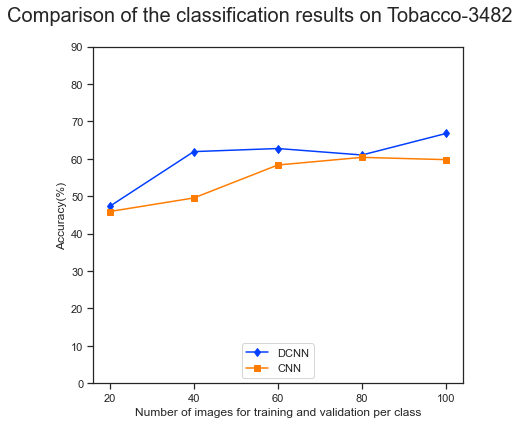

In [9]:
# Comparison of the classification results on Tobaco-3482

sns.set_theme(style="ticks")
sns.set_palette("bright")
fig, axs = plt.subplots( figsize=(6,6))
plt.plot(models_accuracy_df.index, models_accuracy_df['DCNN'], "-d")
plt.plot(models_accuracy_df.index, models_accuracy_df['CNN'], "-s")
plt.legend(["DCNN", "CNN"], loc="lower center")
plt.xlabel("Number of images for training and validation per class")
plt.ylabel("Accuracy(%)")
plt.ylim(0, 90)
fig.suptitle("Comparison of the classification results on Tobacco-3482", fontsize=20)
fig.tight_layout()
fig.savefig("accuracy-vs-the-number-of-images.svg")
plt.show()

### Confusion Matrix
The class confusion matrix of the results obtained by one partition which contains 100 images from each class and rest of the images are used for testing.

In [10]:
# Confusion matric for method DCNN and number of training and validation examples equal to 100

csv_path = os.path.join(log_home_dir, models_log_dir["DCNN"]["100"], "test_result.csv")
# read csv as dataframe
df = pd.read_csv(csv_path, usecols=['label', 'pred'])
labels = ['Ad', 'Email', 'Form', 'Letter', 'Memo', 'News', 'Note', 'Report', 'Resume', 'Scientific']
cm = sklmetrics.confusion_matrix(df.label, df.pred,)
cm

array([[122,   1,   1,   0,   1,   4,   1,   0,   0,   0],
       [  0, 467,   3,   5,  10,   1,   7,   2,   2,   2],
       [  1,  20, 246,   7,  21,   5,   5,   1,  21,   4],
       [  1,  14,   4, 341,  30,   3,   1,  30,  31,  12],
       [  5,  33,  29, 108, 221,   3,   7,  22,  63,  29],
       [  6,   0,   0,   2,   0,  75,   1,   0,   0,   4],
       [  4,   9,  11,   6,   4,   0,  60,   0,   4,   3],
       [  0,  13,   4,  39,  11,   2,   0,  53,  24,  19],
       [  0,   1,   1,   0,   0,   0,   0,   0,  16,   2],
       [  2,   7,  11,  20,  19,  12,   3,  14,  16,  57]], dtype=int64)

In [11]:
cm = cm/(np.sum(cm, axis=1).reshape((10,1)))*100

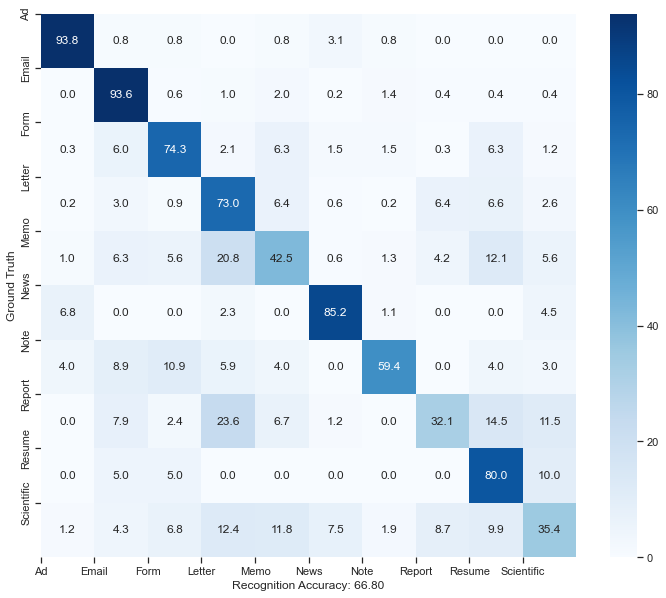

In [12]:
fig, axs = plt.subplots(figsize=(12,10))
sns.heatmap(cm, cmap="Blues", annot=True, fmt='.1f',)
plt.xticks(ticks= np.arange(10), labels = labels)
plt.yticks(ticks= np.arange(10), labels = labels)
plt.xlabel("Recognition Accuracy: {:.2f}".format(sklmetrics.accuracy_score(df.label, df.pred)*100))
plt.ylabel("Ground Truth")
fig.savefig("confusion_matrix.svg")
plt.show()